<a href="https://colab.research.google.com/github/EndCharr/NeuroVocalic-F5/blob/main/Neuro_LipSync.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

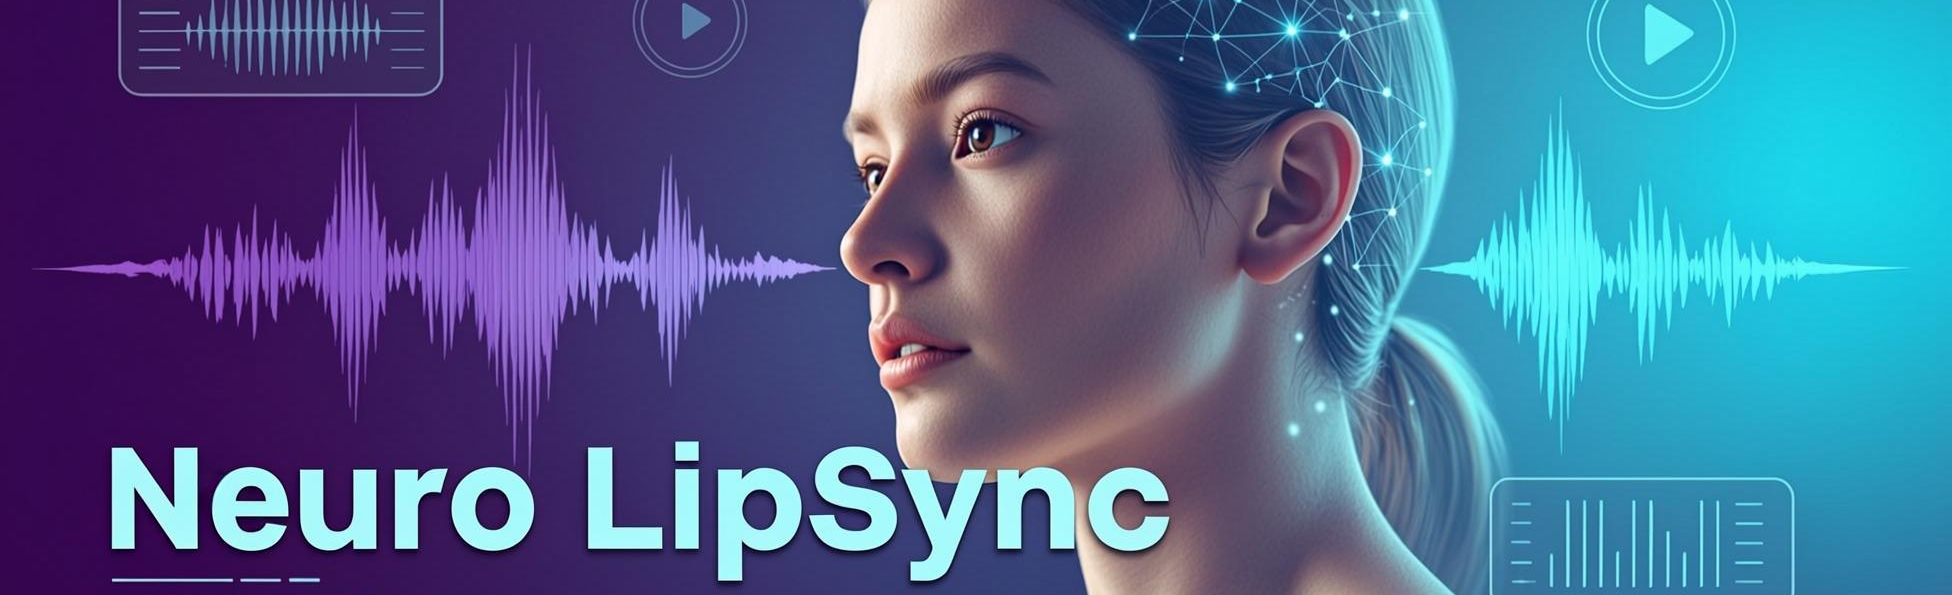

This notebook has been carefully crafted by the Academia Endcharr  Channel: [Here](https://www.youtube.com/@EndCharr), with the purpose of providing a useful and practical tool that facilitates both learning and the automated creation of videos using artificial intelligence, thus optimizing creative and educational processes.

Únete a  mi canal de Telegram: https://t.me/academia_Endcharr

Join my Telegram channel: https://t.me/academia_Endcharr



In [1]:
#@title Install Library
!pip install gradio==5.49.1
!sudo apt-get install ffmpeg -y
!pip install avatarflow-r5
!pip install gradio_button_lm
!pip install pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 107.3 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.4
    Uninstalling pydantic_core-2.41.4:
      Successfully uninstalled pydantic_core-2.41.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.3
    Uninstalling pydantic-2.12.3:
      Successfully uninstalled pydantic-2.12.3
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.14.0
    Uninstalling gradio_client-1.14.0:
      Successfully uninstalled gradio_client-1.14.0
  Attempting uninstall: gradio
    Found existing installation: gradio 5

In [ ]:
#@title Neuro LipSync

import sys
import site
import os
import warnings
import time
import cv2
from pydub import AudioSegment

# --- Gradio y NeuroLipSync (Método Gratuito) ---
# --- MEJORA: Suprimir advertencias ruidosas de la librería interna ---
warnings.filterwarnings("ignore", category=UserWarning, module="gradio.components.video")
# Esta línea oculta los molestos "Error descomprimiendo gzip" que son un bug interno de la librería
warnings.filterwarnings("ignore", message=".*Not a gzipped file.*")

cp_gpu_rtx = site.getsitepackages()[0]
run_gpu_connected = os.path.join(cp_gpu_rtx, "AvatarFlow_R5")
sys.path.insert(0, run_gpu_connected)
warnings.filterwarnings("ignore")
import gradio as gr
from gen import *

# --- CONFIGURACIÓN Y CONSTANTES ---
TEMP_DIR = "/tmp"
OUTPUT_DIR = "/content/video"
AUDIO_FILENAME = "audio.mp3"
VIDEO_FILENAME = "video.mp4"
OUTPUT_FILENAME = "output.mp4"

# Rutas completas
AUDIO_PATH = os.path.join(TEMP_DIR, AUDIO_FILENAME)
VIDEO_PATH = os.path.join(TEMP_DIR, VIDEO_FILENAME)
OUTPUT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

# Asegurarse de que el directorio de salida exista
os.makedirs(OUTPUT_DIR, exist_ok=True)


# --- FUNCIONES AUXILIARES ---

def recortar_mp3_a_20_segundos(ruta_archivo):
    """Recorta un archivo MP3 a un máximo de 20 segundos, límite de la API gratuita."""
    try:
        audio = AudioSegment.from_mp3(ruta_archivo)
        duracion_ms = len(audio)
        duracion_seg = duracion_ms / 1000.0
        if duracion_seg > 20.0:
            print(f"⚠️ El audio dura {duracion_seg:.2f}s. Recortando a 20s para cumplir con el límite gratuito...")
            audio_recortado = audio[:20000]
            audio_recortado.export(ruta_archivo, format="mp3")
            print(f"✅ Audio recortado y guardado.")
        else:
            print(f"✅ Audio de {duracion_seg:.2f}s. Cumple con el límite, no requiere recorte.")
    except Exception as e:
        print(f"❌ Error al procesar el audio: {e}")

def process_and_save_audio(audio_path):
    if not audio_path: return None
    if os.path.exists(AUDIO_PATH): os.remove(AUDIO_PATH)
    try:
        audio = AudioSegment.from_file(audio_path)
        audio.export(AUDIO_PATH, format="mp3")
        if not audio_path.lower().endswith(".mp3"): os.remove(audio_path)
        recortar_mp3_a_20_segundos(AUDIO_PATH)
        return AUDIO_PATH
    except Exception as e:
        print(f"❌ Error al procesar el audio: {str(e)}")
        return None

def process_and_save_video(video_path):
    if not video_path: return None
    if os.path.exists(VIDEO_PATH): os.remove(VIDEO_PATH)
    try:
        if video_path.lower().endswith(".mp4"):
            os.rename(video_path, VIDEO_PATH)
        else:
            os.system(f"ffmpeg -i '{video_path}' -c:v libx264 -c:a aac -y '{VIDEO_PATH}'")
            if not video_path.lower().endswith(".mp4"): os.remove(video_path)

        cap = cv2.VideoCapture(VIDEO_PATH)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()

        print(f"✅ Video guardado en {VIDEO_PATH} | Dimensiones: {width}x{height}")
        os.environ["WIDTH_TOKEN"] = str(width)
        os.environ["HEIGHT_TOKEN"] = str(height)
        return VIDEO_PATH
    except Exception as e:
        print(f"❌ Error al procesar el video: {str(e)}")
        return None


# --- FUNCIÓN PRINCIPAL ROBUSTA ---
def lipsync_generation(video_input, audio_input, version, progress=gr.Progress()):
    """
    Genera el video de Lipsync usando el método gratuito automatizado.
    """
    if not video_input or not audio_input:
        return None, "❌ Error: Faltan archivos de video o audio"

    if os.path.exists(OUTPUT_PATH):
        os.remove(OUTPUT_PATH)

    try:
        progress(0.1, desc="Iniciando proceso gratuito (puede ser lento)...")

        progress(0.3, desc="Automatizando cuenta y subiendo archivos...")
        gen_ava(version)

        progress(0.8, desc="Esperando el resultado de la API...")
        time.sleep(5)

        if os.path.exists(OUTPUT_PATH):
            progress(1.0, desc="¡Completado!")
            return OUTPUT_PATH, "✅ Neuro LipSync generado con éxito."
        else:
            return None, "❌ Error: El proceso falló. Esto puede ocurrir si el servicio gratuito está saturado. Revisa la consola para más detalles o inténtalo de nuevo más tarde."

    except Exception as e:
        return None, f"❌ Ocurrió un error inesperado: {str(e)}"


# --- INTERFAZ DE GRADIO ---
with gr.Blocks(theme=gr.themes.Default(primary_hue="blue", secondary_hue="cyan"), css='''
    /* Estilos CSS para Neuro LipSync */
    body {
        background-color: #0d1b2a; /* Fondo oscuro tipo academia */
        color: #E0E1DD; /* Texto gris claro */
    }
    .gradio-container {
        font-family: 'Segoe UI', 'Roboto', sans-serif;
    }
    .neuro-button {
        background: linear-gradient(45deg, #00b4d8, #0077b6); /* Degradado azul */
        color: #FFFFFF;
        border: none;
        border-radius: 8px;
        padding: 12px 20px;
        font-weight: bold;
        cursor: pointer;
        transition: all 0.3s ease;
        box-shadow: 0 4px 15px rgba(0, 119, 182, 0.3);
    }
    .neuro-button:hover {
        background: linear-gradient(45deg, #0077b6, #00b4d8);
        transform: translateY(-2px);
        box-shadow: 0 6px 20px rgba(0, 180, 216, 0.4);
    }
    .neuro-image {
        border: 2px solid #0077b6; /* Borde azul */
        border-radius: 12px;
        box-shadow: 0 4px 12px rgba(0, 119, 182, 0.2);
    }
    .neuro-textbox {
        border: 1px solid #0077b6;
        border-radius: 8px;
    }
''') as demo:
    # --- HTML con el nombre y creador ---
    gr.HTML('''
        <div style="text-align: center; padding: 25px; background: linear-gradient(135deg, #0d1b2a, #1b263b); border-radius: 15px; border: 1px solid #0077b6;">
            <h1 style="font-size: 3em; color: #00b4d8; margin: 0; text-shadow: 0 0 10px rgba(0, 180, 216, 0.5);">Neuro LipSync</h1>
            <p style="font-size: 1.2em; color: #E0E1DD; margin: 10px 0;">
                Creado por: <a href="https://www.youtube.com/@EndCharr" target="_blank" style="color: #90e0ef; text-decoration: none; font-weight: bold;">Academia Endcharr</a>
            </p>
        </div>
    ''')

    with gr.Tabs():
        # --- nombre para la pestaña ---
        with gr.TabItem("Neuro LipSync"):
            # --- Advertencias actualizada ---
            gr.Markdown("""
            ### ⚠️ Información del Proceso
            Este método es **Gratuito y puede ser lento**. Automatiza el uso de créditos gratuitos.
            - **Audio:** Máximo 20 segundos.
            - **Velocidad:** Puede tardar de 2 a 10 minutos.
            - **Fiabilidad:** Puede fallar si el servicio está saturado. Si ocurre, inténtalo más tarde.
            """)
            with gr.Row():
                with gr.Column():
                    version_radio = gr.Dropdown(
                        choices=["1.9.0", "2.0.0", "2.0.5", "2.1.0"],
                        label="Versión del Modelo",
                        value="2.0.5",
                        info="Versiones más nuevas pueden dar mejores resultados."
                    )
                    video_input_lipsync = gr.Video(label="Sube tu video (MP4)", elem_classes="neuro-image")
                    audio_input_lipsync = gr.Audio(label="Sube tu audio (máx. 20 seg)", type="filepath", elem_classes="neuro-image")

                    # --- texto para el botón ---
                    lipsync_button = gr.Button("🧠 Generar Neuro LipSync", elem_classes="neuro-button", variant="primary")

                with gr.Column():
                    lipsync_video_output = gr.Video(label="Resultado del Neuro LipSync", elem_classes="neuro-image")
                    lipsync_logs = gr.Textbox(label="Estado y Logs", lines=10, elem_classes="neuro-textbox", interactive=False)

            # --- CONEXIÓN DE EVENTOS ---
            video_input_lipsync.upload(fn=process_and_save_video, inputs=video_input_lipsync, outputs=video_input_lipsync)
            audio_input_lipsync.upload(fn=process_and_save_audio, inputs=audio_input_lipsync, outputs=audio_input_lipsync)

            lipsync_button.click(
                fn=lipsync_generation,
                inputs=[video_input_lipsync, audio_input_lipsync, version_radio],
                outputs=[lipsync_video_output, lipsync_logs]
            )

# Lanzar la aplicación
demo.launch(inline=False, debug=True, share=True)

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://99812440a2f52ecd7c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
